In [1]:
from typing import Optional, Union

import torch
from torch import nn
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from transformers import CLIPForImageClassification, Trainer, TrainingArguments
from transformers import BlipConfig, BlipModel, BlipVisionModel, BlipPreTrainedModel
from transformers.modeling_outputs import ImageClassifierOutput


# Класс наподобие CLIPForImageClassification
class BlipForImageClassification(BlipPreTrainedModel):
    """
    Классификатор с BLIP Vision Encoder
    """

    def __init__(self, config: BlipConfig) -> None:
        super().__init__(config)
        self.num_labels = config.num_labels
        vision_model = BlipVisionModel._from_config(
            config.vision_config, attn_implementation=config._attn_implementation
        )
        self.vision_model = vision_model

        # Classifier head
        self.classifier = (
            nn.Linear(config.vision_config.hidden_size, config.num_labels) if config.num_labels > 0 else nn.Identity()
        )

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.vision_model(
            pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        # average pool the patch tokens
        sequence_output = torch.mean(sequence_output[:, 1:, :], dim=1)
        # apply classifier
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
from transformers import BlipProcessor

model_name = "Salesforce/blip-image-captioning-large"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForImageClassification.from_pretrained(model_name, num_labels=2)

for param in model.vision_model.parameters():
    param.requires_grad = False

In [3]:
from datasets import load_dataset
from pathlib import Path

print("Dataset loading...")
data_dir = Path('../data')
ds = load_dataset("imagefolder", data_dir=data_dir, split="train")
print(ds.features)
print("Done")

Dataset loading...


Resolving data files:   0%|          | 0/6602 [00:00<?, ?it/s]

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['cigs', 'other', 'pipes', 'roll_cigs', 'smoking'], id=None)}
Done


In [ ]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(224, 224)):

    w, h = size
    labels = ds.features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    # font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds.filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (0, 255, 0))

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [5]:
from typing import Tuple, List
from dataclasses import dataclass

from torch.utils.data import Dataset, DataLoader

@dataclass
class ImageDataset(Dataset):
    dataset: Dataset
    processor: BlipProcessor
    positive_labels:List[str]

    def __len__(self)->int:
        return len(self.dataset)
    
    def __getitem__(self, idx: int)->Tuple:
        image = self.dataset[idx]['image'].convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        inputs['pixel_values'] = inputs['pixel_values'].squeeze(0)
        label = self.dataset[idx]['label']
        label_string = self.dataset.features['label'].int2str(label)
        label = 1 if label_string in self.positive_labels else 0
        inputs['label'] = label
        return inputs

train_test_split = ds.train_test_split(test_size=0.2)
train_ds = train_test_split['train']
val_ds = train_test_split['test']

positive_classes = list(filter(lambda name: name!='other', ds.features['label'].names))
train_ds = ImageDataset(train_ds, processor, positive_classes)
val_ds = ImageDataset(val_ds, processor, positive_classes)

In [7]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
auc = evaluate.load("roc_auc")

In [8]:
import numpy as np
from scipy.special import softmax

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy_val = accuracy.compute(predictions=predictions, references=labels)
    f1_val = f1.compute(predictions=predictions, references=labels)
    precision_val = precision.compute(predictions=predictions, references=labels)
    recall_val = recall.compute(predictions=predictions, references=labels)
    
    preds = softmax(logits, axis=1)[:,1]
    auc_value = auc.compute(
        prediction_scores=preds,
        references=labels)
    
    return accuracy_val | f1_val | precision_val | recall_val | auc_value

In [10]:
from transformers import TrainingArguments
# Define the training arguments
train_batch_size = 16
training_args = TrainingArguments(
    output_dir=Path('../data/models/blip-large-probe-2'),
    eval_strategy="epoch",
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    logging_dir=Path('../data/logs'),
    logging_steps=10,
    save_steps=len(train_ds) // train_batch_size,
    save_total_limit=None,
    fp16=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)
trainer.train()

In [ ]:
from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

y_preds = torch.Tensor().to(device)
y_true = torch.Tensor().to(device)
progress_bar = tqdm(total=len(val_ds))
data_loader = DataLoader(val_ds, batch_size=128, shuffle=True)
step = data_loader.batch_size

for batch in data_loader:
    images, labels = batch['pixel_values'], batch['label']
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(images)
    probs = outputs.logits.softmax(dim=1)
    y_preds = torch.concat([y_preds, probs])
    y_true = torch.concat([y_true, labels])
    
    progress_bar.update(step)

In [78]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

positive_labels = ['cigs', 'pipes', 'roll_cigs', 'smoking']
y_preds_arr = y_preds.to('cpu').numpy()[:, 1]

y_true_arr = y_true.to('cpu').numpy().astype(np.int32)
threshold = 0.5
accuracy_score(y_true_arr, y_preds_arr>threshold), precision_score(y_true_arr, y_preds_arr>threshold), recall_score(y_true_arr, y_preds_arr>threshold), f1_score(y_true_arr, y_preds_arr>threshold), roc_auc_score(y_true_arr, y_preds_arr)

(0.9856169568508706,
 0.9816326530612245,
 0.9796334012219959,
 0.9806320081549439,
 0.9993472873162712)

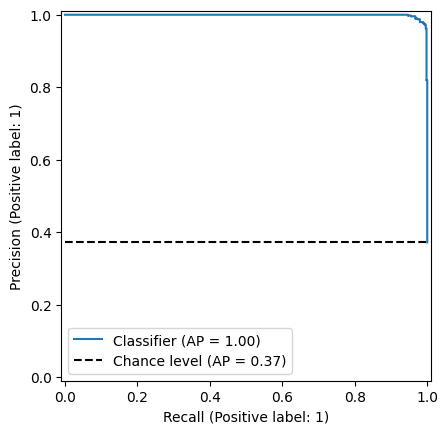

In [79]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

PrecisionRecallDisplay.from_predictions(y_true_arr, y_preds_arr, plot_chance_level=True)
plt.show()

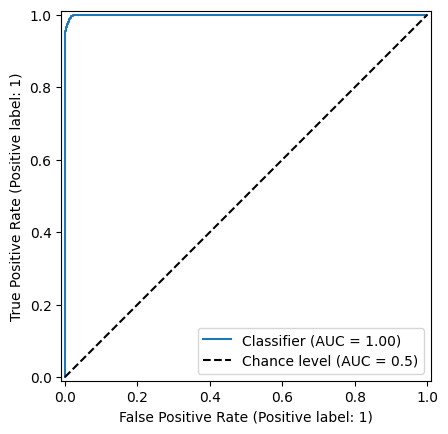

In [80]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_true_arr, y_preds_arr, plot_chance_level=True)
plt.show()